In [1]:
import talib

In [2]:
import os
import numpy as np
import math
import joblib
import schedule
import pandas as pd
import plotly.graph_objects as go
import time as st_time
from datetime import datetime, date, timedelta, time
os.environ['TZ'] ='America/New_York'

#import yfinance as yf

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

from ib_async import *
util.startLoop()

from math import sqrt

from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression

In [3]:
ib = IB()
ib.connect(port=7496, clientId=10)

<IB connected to 127.0.0.1:7496 clientId=10>

Error 1100, reqId -1: Connectivity between IBKR and Trader Workstation has been lost.
Error 1100, reqId -1: Connectivity between IBKR and Trader Workstation has been lost.


In [4]:
symbol ='NFLX'

In [5]:
contract = Contract(symbol=symbol, secType='STK', exchange='SMART', currency='USD')
ib.qualifyContracts(contract)

[Contract(secType='STK', conId=15124833, symbol='NFLX', exchange='SMART', primaryExchange='NASDAQ', currency='USD', localSymbol='NFLX', tradingClass='NMS')]

In [17]:
# duration is fixed for an year
def simple_data_req( contract, end_date , barsize ="1 min", data_clean = True):

   
    df_acc=pd.DataFrame()
    df_hist=pd.DataFrame()

    for i in range(1):
        print(f'fetching data for {i}')
        bars = ib.reqHistoricalData(contract= contract, endDateTime=end_date, barSizeSetting= barsize, durationStr= "3 D", whatToShow="TRADES", useRTH=True)
        df = util.df(bars)
        end_date = end_date - timedelta(i)
        df_acc = pd.concat([df, df_acc], ignore_index=True)
        print(f"head date {df_acc.head(1)['date']}")
        print(f"tail date {df_acc.tail(1)['date']}")

    if barsize !='1 day':
    
        df_acc['Date_Only'] = df_acc['date'].dt.date
        
    if (data_clean == True) & (barsize !='1 day'):
        df_hist = df_acc[(df_acc['date'].dt.time >= time(9, 30)) & (df_acc['date'].dt.time < time(16, 00))]
    else:
        df_hist = df_acc

    df_hist.drop_duplicates(inplace=True)
    
    return df_hist

In [18]:
end_date = date(2025, 4, 25)

In [19]:
barsize ="5 mins"
df_all_days_stock=pd.DataFrame()
df_all_days_stock = simple_data_req(contract = contract, end_date = end_date, barsize= barsize )

fetching data for 0
head date 0   2025-04-23 09:30:00-04:00
Name: date, dtype: datetime64[ns, US/Eastern]
tail date 177   2025-04-25 11:15:00-04:00
Name: date, dtype: datetime64[ns, US/Eastern]


In [20]:
series = df_all_days_stock['close']
series.index = np.arange(series.shape[0])

In [21]:
def pythag(pt1, pt2):
    a_sq = (pt2[0] - pt1[0]) ** 2
    b_sq = (pt2[1] - pt1[1]) ** 2
    return sqrt(a_sq + b_sq)

In [22]:
def regression_ceof(pts):
    X = np.array([pt[0] for pt in pts]).reshape(-1, 1)
    y = np.array([pt[1] for pt in pts])
    model = LinearRegression()
    model.fit(X, y)
    return model.coef_[0], model.intercept_

In [23]:
def local_min_max(pts):
    local_min = []
    local_max = []
    prev_pts = [(0, pts[0]), (1, pts[1])]
    for i in range(1, len(pts) - 1):
        append_to = ''
        if pts[i-1] > pts[i] < pts[i+1]:
            append_to = 'min'
        elif pts[i-1] < pts[i] > pts[i+1]:
            append_to = 'max'
        if append_to:
            if local_min or local_max:
                prev_distance = pythag(prev_pts[0], prev_pts[1]) * 0.5
                curr_distance = pythag(prev_pts[1], (i, pts[i]))
                if curr_distance >= prev_distance:
                    prev_pts[0] = prev_pts[1]
                    prev_pts[1] = (i, pts[i])
                    if append_to == 'min':
                        local_min.append((i, pts[i]))
                    else:
                        local_max.append((i, pts[i]))
            else:
                prev_pts[0] = prev_pts[1]
                prev_pts[1] = (i, pts[i])
                if append_to == 'min':
                    local_min.append((i, pts[i]))
                else:
                    local_max.append((i, pts[i]))
    return local_min, local_max

In [24]:
month_diff = series.shape[0] // 30
if month_diff == 0:
    month_diff = 1
month_diff
smooth = int(2 * month_diff + 3)
smooth

13

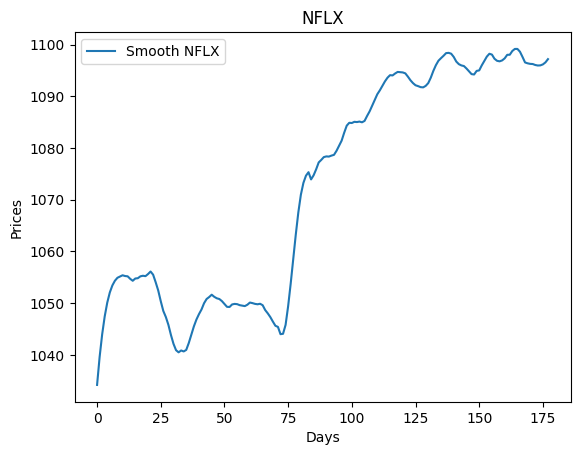

In [26]:
pts = savgol_filter(series, smooth, 3)
plt.title(symbol)
plt.xlabel('Days')
plt.ylabel('Prices')
plt.plot(pts, label=f'Smooth {symbol}')
plt.legend()

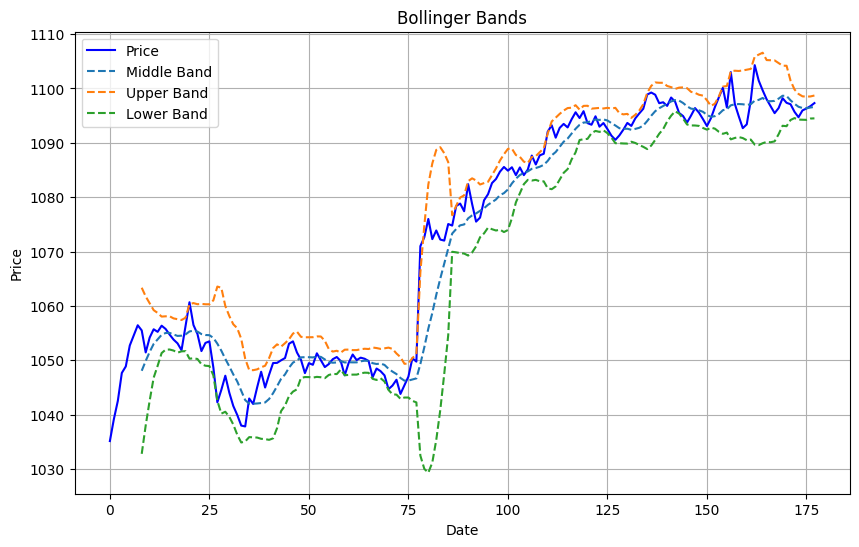

In [27]:

def calculate_bollinger_bands(data, window=9, num_std=2):
  """
    Calculates Bollinger Bands for a given time series data.

    Args:
        data (pd.Series): Time series data (e.g., closing prices).
        window (int): Rolling window size for calculating the moving average and standard deviation.
        num_std (int): Number of standard deviations to calculate the upper and lower bands.

    Returns:
        pd.DataFrame: DataFrame containing the middle band (moving average), upper band, and lower band.
    """
  rolling_mean = data.rolling(window=window).mean()
  rolling_std = data.rolling(window=window).std()
  
  upper_band = rolling_mean + (rolling_std * num_std)
  lower_band = rolling_mean - (rolling_std * num_std)
  
  bollinger_df = pd.DataFrame({
      'Middle Band': rolling_mean,
      'Upper Band': upper_band,
      'Lower Band': lower_band
  })
  return bollinger_df

# Sample usage with dummy data

price_data = series

# Calculate Bollinger Bands
bbands = calculate_bollinger_bands(price_data)

# Plot the data and Bollinger Bands
plt.figure(figsize=(10, 6))
plt.plot(price_data, label='Price', color='blue')
plt.plot(bbands['Middle Band'], label='Middle Band', linestyle='--')
plt.plot(bbands['Upper Band'], label='Upper Band', linestyle='--')
plt.plot(bbands['Lower Band'], label='Lower Band', linestyle='--')
plt.title('Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
local_min, local_max = local_min_max(pts)
all_points = local_min + local_max
arr = []
for i, j in all_points:
    arr.append(j)

arr = np.array(arr)
    

In [29]:


def group_close_numbers(arr, threshold):
    arr_sorted = np.sort(arr)
    diffs = np.diff(arr_sorted)
    group_indices = np.where(diffs > threshold)[0] + 1
    groups = np.split(arr_sorted, group_indices)
    return groups

# Example usage:
threshold = 1
result = group_close_numbers(arr, threshold)
print(result)

key_line = []

for i in result:
    if len(i) >= 2:
        print(i.mean())
        key_line.append(i.mean())
# Expected output: [array([1, 2, 3, 5]), array([ 8]), array([15]), array([20, 22])]

[array([1040.47678322]), array([1043.9893007]), array([1049.77706294, 1049.84972028, 1050.11293706]), array([1051.63006993]), array([1055.38965035, 1056.11552448]), array([1075.34328671]), array([1084.90258741]), array([1091.75741259]), array([1094.11923077, 1094.2506993 ]), array([1095.98923327, 1096.79622378]), array([1098.26237762, 1098.43797203, 1099.19881119])]
1049.913240093237
1055.752587412584
1094.1849650349618
1096.3927285214763
1098.6330536130502


In [30]:
key_line

[np.float64(1049.913240093237),
 np.float64(1055.752587412584),
 np.float64(1094.1849650349618),
 np.float64(1096.3927285214763),
 np.float64(1098.6330536130502)]

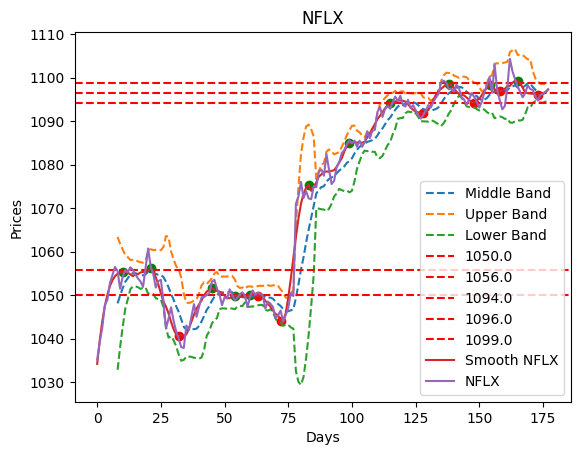

In [31]:


fig, ax = plt.subplots()


plt.plot(bbands['Middle Band'], label='Middle Band', linestyle='--')
plt.plot(bbands['Upper Band'], label='Upper Band', linestyle='--')
plt.plot(bbands['Lower Band'], label='Lower Band', linestyle='--')

for i in key_line:
    ax.axhline(y=i, color='r', linestyle='--', label=i.round())

plt.title(symbol)
plt.xlabel('Days')
plt.ylabel('Prices')
plt.plot(pts, label=f'Smooth {symbol}')
for pt in local_min:
    plt.scatter(pt[0], pt[1], c='r')
for pt in local_max:
    plt.scatter(pt[0], pt[1], c='g')


plt.plot(series, label=symbol)




plt.legend()

In [ ]:
df = df_all_days_stock.copy()

In [ ]:
def detect_candlestick_patterns(df):
    # Drop rows with missing values
    #df = df.dropna(subset=['Open', 'High', 'Low', 'Adj Close'])

    # Check if there are enough rows to calculate patterns
    if len(df) < 5:
        print("Not enough data to detect patterns.")
        return df

    # Convert DataFrame columns to numpy arrays
    open_prices = df['open'].values.reshape(-len(df),)
    high_prices = df['high'].values.reshape(-len(df),)
    low_prices = df['low'].values.reshape(-len(df),)
    close_prices = df['close'].values.reshape(-len(df),)  # Use 'Adj Close' instead of 'Close'
    
    # Ensure all arrays have the same length
    if not (len(open_prices) == len(high_prices) == len(low_prices) == len(close_prices)):
        print("Input arrays have different lengths.")
        return df
    
    # Candlestick pattern detection
    patterns = {
        'DOJI' : talib.CDLDOJI(open_prices, high_prices, low_prices, close_prices),
        'HANGINGMAN' :talib.CDLHANGINGMAN(open_prices, high_prices, low_prices, close_prices),
        'Engulfing': talib.CDLENGULFING(open_prices, high_prices, low_prices, close_prices),
        'MORNINGSTAR': talib.CDLMORNINGSTAR(open_prices, high_prices, low_prices, close_prices, penetration=0.3),
        'HAMMER': talib.CDLHAMMER(open_prices, high_prices, low_prices, close_prices),
        'INVERTEDHAMMER': talib.CDLINVERTEDHAMMER(open_prices, high_prices, low_prices, close_prices),
        'PIERCING': talib.CDLPIERCING(open_prices, high_prices, low_prices, close_prices),
        '3WHITESOLDIERS': talib.CDL3WHITESOLDIERS(open_prices, high_prices, low_prices, close_prices),
        'RISEFALL3METHODS': talib.CDLRISEFALL3METHODS(open_prices, high_prices, low_prices, close_prices),
    }

    # Add detected patterns to the DataFrame
    for pattern_name, pattern in patterns.items():
        df[pattern_name] = pattern
    return df


# Filter for selected patterns
def filter_patterns(df):

    detected_patterns = df[(df['DOJI'] != 0) |
                            (df['HANGINGMAN'] != 0) |
                            (df['Engulfing'] != 0) |
                           (df['MORNINGSTAR'] != 0) |
                           (df['HAMMER'] != 0) |
                           (df['INVERTEDHAMMER'] != 0) |
                           (df['PIERCING'] != 0) |
                           (df['3WHITESOLDIERS'] != 0) |
                           (df['RISEFALL3METHODS'] != 0)]
    return detected_patterns

In [ ]:
df_with_patterns = detect_candlestick_patterns(df)

In [ ]:
pattern_counts = df[['DOJI','HANGINGMAN','Engulfing','INVERTEDHAMMER', 'MORNINGSTAR', 'HAMMER', 'PIERCING', 
                     '3WHITESOLDIERS', 
                     'RISEFALL3METHODS']].apply(lambda x: x[x != 0].count())
pattern_counts

In [ ]:
df_with_patterns = detect_candlestick_patterns(df)
detected_patterns = filter_patterns(df_with_patterns)

In [ ]:
detected_patterns

In [ ]:
df_test = df_with_patterns.copy()

In [ ]:
def heavy(x):
    a = df_test['volume'].mean()
    if x > 1*a:
        return True
    else:
        return False

In [ ]:
df_test['heavy_V']=df_test['volume'].apply(heavy)

In [ ]:
def calculate_rsi(data, period=12):
    """
    Calculates the Relative Strength Index (RSI) for a given dataset.

    Args:
        data (pd.Series): A Pandas Series representing the price data.
        period (int, optional): The lookback period for calculating RSI. Defaults to 14.

    Returns:
        pd.Series: A Pandas Series containing the RSI values.
    """
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    
    avg_gain = gain.rolling(window=period, min_periods=period).mean()
    avg_loss = loss.rolling(window=period, min_periods=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [ ]:

def calculate_macd(data, fast_period=12, slow_period=26, signal_period=9):
    """
    Calculates the MACD indicator for a given time series data.

    Args:
        data (pd.Series): Time series data (e.g., closing prices).
        fast_period (int): Period for the fast EMA (default: 12).
        slow_period (int): Period for the slow EMA (default: 26).
        signal_period (int): Period for the signal line EMA (default: 9).

    Returns:
        pd.DataFrame: DataFrame containing MACD, signal line, and histogram.
    """
    fast_ema = data.ewm(span=fast_period, adjust=False).mean()
    slow_ema = data.ewm(span=slow_period, adjust=False).mean()
    macd_line = fast_ema - slow_ema
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    histogram = macd_line - signal_line

    macd_df = pd.DataFrame({
        'MACD': macd_line,
        'Signal_Line': signal_line,
        'Histogram': histogram
    })
    return macd_df

# Example usage with sample data
#data = pd.Series(np.random.rand(100))
data = df_test['close']
df_test['MACD']= calculate_macd(data)['MACD']
df_test['diff_MACD'] = df_test['MACD'].diff()
#df_META['MACD_Sig'] =calculate_macd(data)['Signal_Line']
#df_META['diff_M_Sig'] = df_META['MACD_Sig'].diff()
df_test['RSI_12'] = calculate_rsi(df_test['close'])
df_test['diff_RSI'] = df_test['RSI_12'].diff()
#df_META['diff_RSI_MACD'] = calculate_rsi(df_META['diff_MACD'])

In [ ]:

# Assuming df_test is your DataFrame with a DateTime index
fig = go.Figure(data=[go.Candlestick(x=df_test.index,
                                     open=df_test['open'],
                                     high=df_test['high'],
                                     low=df_test['low'],
                                     close=df_test['close'],
                                     name='Nifty Candlestick')])

# Add annotations for patterns
pattern_columns = ['DOJI','HANGINGMAN','Engulfing','INVERTEDHAMMER', 'MORNINGSTAR', 'HAMMER', 'PIERCING', 
                     '3WHITESOLDIERS', 
                     'RISEFALL3METHODS']

for idx in range(len(df_test)):
    for pattern in pattern_columns:
        if df_test.iloc[idx][pattern] != 0 and df_test.iloc[idx]['heavy_V'] == True: # edited
            if (df_test.iloc[idx]['diff_MACD'] > 0) &  (df_test.iloc[idx]['RSI_12'] > 30) &  (df_test.iloc[idx]['diff_RSI'] > 0)  == True:
                fig.add_annotation(
                    x=df_test.index[idx],
                    y=df_test.iloc[idx]['high'] + (df_test.iloc[idx]['high'] - df_test.iloc[idx]['low']) * 0.3,  # Adjust the offset to be 10% of the candle height
                    text=pattern,
                    showarrow=True,
                    arrowhead=1,
                    textangle=90,
                    yshift=5  # Optional: Shift the text slightly down if needed
                )


fig.update_xaxes(
    rangeslider_visible=False,
    rangebreaks=[
        # Remove weekends
        dict(bounds=["sat", "mon"]),  # Skips Saturday and Sunday
        
        # Remove non-trading hours
        dict(bounds=[16, 9.5], pattern="hour"),  # Skips from 4:00 PM (16) to 9:30 AM (9.5)
        
        # Optionally, remove specific holidays by specifying exact dates
        # dict(values=["2024-01-01", "2024-12-25"])
    ]
)


# Customize the layout
fig.update_layout(title='S&P500 Candlestick Chart with Skipped Non-Trading Hours',
                  xaxis_title='Date',
                  yaxis_title='Price',
                  width=1000,
                  height=600)

fig.update_layout(
    dragmode='zoom',  # Default interaction is zoom
    hovermode='x',    # Hover effect on the x-axis
    xaxis_rangeslider_visible=False  # Keep the range slider hidden
)

# Display the interactive plot
fig.show()

In [ ]:

# Assuming df_test is your DataFrame with a DateTime index
fig = go.Figure(data=[go.Candlestick(x=df_test.index,
                                     open=df_test['open'],
                                     high=df_test['high'],
                                     low=df_test['low'],
                                     close=df_test['close'],
                                     name='Nifty Candlestick')])

# Add annotations for patterns
pattern_columns = ['DOJI','HANGINGMAN','Engulfing','INVERTEDHAMMER', 'MORNINGSTAR', 'HAMMER', 'PIERCING', 
                     '3WHITESOLDIERS', 
                     'RISEFALL3METHODS']

for idx in range(len(df_test)):
    for pattern in pattern_columns:
        if df_test.iloc[idx][pattern] != 0 :  # edited
           
            fig.add_annotation(
                x=df_test.index[idx],
                y=df_test.iloc[idx]['high'] + (df_test.iloc[idx]['high'] - df_test.iloc[idx]['low']) * 0.3,  # Adjust the offset to be 10% of the candle height
                text=pattern,
                showarrow=True,
                arrowhead=1,
                textangle=90,
                yshift=5  # Optional: Shift the text slightly down if needed
                )


fig.update_xaxes(
    rangeslider_visible=False,
    rangebreaks=[
        # Remove weekends
        dict(bounds=["sat", "mon"]),  # Skips Saturday and Sunday
        
        # Remove non-trading hours
        dict(bounds=[16, 9.5], pattern="hour"),  # Skips from 4:00 PM (16) to 9:30 AM (9.5)
        
        # Optionally, remove specific holidays by specifying exact dates
        # dict(values=["2024-01-01", "2024-12-25"])
    ]
)


# Customize the layout
fig.update_layout(title='S&P500 Candlestick Chart with Skipped Non-Trading Hours',
                  xaxis_title='Date',
                  yaxis_title='Price',
                  width=1000,
                  height=600)

fig.update_layout(
    dragmode='zoom',  # Default interaction is zoom
    hovermode='x',    # Hover effect on the x-axis
    xaxis_rangeslider_visible=False  # Keep the range slider hidden
)

# Display the interactive plot
fig.show()

In [ ]:
# Calculate AVGH10, AVGL10, MINL10, and STOC1
AVGH10 = df['high'].rolling(window=10).mean()
AVGL10 = df['low'].rolling(window=10).mean()
MINL10 = df['low'].rolling(window=10).min()
STOC1 = 100 * (df['close'] - MINL10) / (AVGH10 - MINL10)

In [ ]:
O1 = df['open'].shift(1)
C1 = df['close'].shift(1)

# Add a new column 'Engulfing' to indicate if the Engulfing pattern is identified
df['Engulfing'] = np.where(
    (O1 > C1) &                                          # Condition 1
    (10 * (df['close'] - df['open']) >= 7 * (df['high'] - df['low'])) &  # Condition 2
    (df['close'] > O1) &                                        # Condition 3
    (C1 > df['open']) &                                         # Condition 4
    (10 * (df['high'] - df['low']) >= 12 * (AVGH10 - AVGL10)) & # Condition 5
    (~np.isnan(AVGH10) & ~np.isnan(AVGL10)),  # Ensure no NaN values
    1,  # If all conditions are met
    0   # Otherwise
)

df[df['Engulfing'] != 0].head()

In [ ]:
df['DOJI'] = np.where(
    (20 * abs(df['open'] - df['close']) <= df['high'] - df['low']) &  # Condition
    (~df[['high', 'low', 'open', 'close']].isna().any(axis=1)),      # Ensure no NaN values
    1,  # If the condition is met
    0   # Otherwise
)

df[df['DOJI'] != 0]

In [ ]:
# Shift the DataFrame by one and two to get the previous days' and two days ago's open, Close, high, and low
O1 = df['open'].shift(1)
C1 = df['close'].shift(1)
H1 = df['high'].shift(1)
L1 = df['low'].shift(1)

O2 = df['open'].shift(2)
C2 = df['close'].shift(2)
H2 = df['high'].shift(2)
L2 = df['low'].shift(2)

# Add a new column 'MorningStar' to indicate if the Morning Star pattern is identified
df['MORNINGSTAR'] = np.where(
    (O2 > C2) &                                            # Condition 1
    (5 * (O2 - C2) > 3 * (H2 - L2)) &          # Condition 2
    (C2 > O1) &                                            # Condition 3
    (2 * abs(O1 - C1) < abs(O2 - C2)) &        # Condition 4
    (H1 - L1 > 3 * (C1 - O1)) &                # Condition 5
    (df['close'] > df['open']) &                                       # Condition 6
    (df['open'] > O1) &                                          # Condition 7
    (df['open'] > C1) &                                          # Condition 8
    ((~np.isnan(O2) & ~np.isnan(C2) & ~np.isnan(O1) & ~np.isnan(H1))),  # Ensure no NaN values
    1,  # If all conditions are met
    0   # Otherwise
)

df[df['MORNINGSTAR'] != 0]

In [ ]:
MINL5 = df['low'].rolling(window=5).min()

# Implement the pattern formula
df['HAMMER'] = np.where(
    (5 * abs(df['close'] - df['open']) <= df['high'] - df['low']) &            # Condition 1
    (10 * abs(df['open'] - df['close']) >= df['high'] - df['low']) &           # Condition 2
    (2 * df['open'] >= df['high'] + df['low']) &                               # Condition 3
    (STOC1 >= 50) &                                                      # Condition 4
    ((20 * df['open'] >= 19 * df['high'] + df['low']) | (STOC1 >= 95)) & # Condition 5 (OR condition)
    (10 * (df['high'] - df['low']) >= 8 * (AVGH10 - AVGL10)) &     # Condition 6
    (df['low'] == MINL5) &                                               # Condition 7
    (df['high'] > df['low']),                                                  # Condition 8
    1,  # If all conditions are met
    0   # Otherwise
)

df[df['HAMMER'] == 1]

In [ ]:
AVGH10_1 = df['high'].shift(1).rolling(window=10).mean()
AVGL10_1 = df['low'].shift(1).rolling(window=10).mean()

# Define the Harami pattern based on the given formula
df['HARAMI'] = np.where(
    (10 * (O1 - C1) >= 7 * (H1 - L1)) &  # Condition 1
    (H1 - L1 >= AVGH10_1 - AVGL10_1) &                          # Condition 2
    (df['close'] > df['open']) &                                                                             # Condition 3
    (df['open'] > C1) &                                                                    # Condition 4
    (O1 > df['close']) &                                                                    # Condition 5
    (6 * (O1 - C1) >= 10 * (df['close'] - df['open'])),                   # Condition 6
    1,  # If all conditions are met
    0   # Otherwise
)

df[df['HARAMI'] != 0].head()

In [ ]:
# Counting occurrences of each pattern
pattern_counts = df[['DOJI', 'Engulfing', 'HAMMER', 'HANGINGMAN', 
                     'HARAMI', 
                     'MORNINGSTAR']].apply(lambda x: x[x != 0].count())

In [ ]:
pattern_counts

In [ ]:
local_min_slope, local_min_int = regression_ceof(local_min)
local_max_slope, local_max_int = regression_ceof(local_max)
support = (local_min_slope * np.array(series.index)) + local_min_int
resistance = (local_max_slope * np.array(series.index)) + local_max_int

In [ ]:
plt.title(symbol)
plt.xlabel('Days')
plt.ylabel('Prices')
plt.plot(series, label=symbol)
plt.plot(support, label='Support', c='r')
plt.plot(resistance, label='Resistance', c='g')
plt.legend()

In [ ]:
df_test = df.copy()

In [ ]:
df_test['volume'].mean()

In [ ]:
def heavy(x):
    a = df_test['volume'].mean()
    if x > a:
        return True
    else:
        return False

In [ ]:
df_test['heavy_V']=df_test['volume'].apply(heavy)

In [ ]:
df_test['heavy_V'].value_counts()

In [ ]:
def calculate_rsi(data, period=4):
    """
    Calculates the Relative Strength Index (RSI) for a given dataset.

    Args:
        data (pd.Series): A Pandas Series representing the price data.
        period (int, optional): The lookback period for calculating RSI. Defaults to 14.

    Returns:
        pd.Series: A Pandas Series containing the RSI values.
    """
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    
    avg_gain = gain.rolling(window=period, min_periods=period).mean()
    avg_loss = loss.rolling(window=period, min_periods=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [ ]:

def calculate_macd(data, fast_period=12, slow_period=26, signal_period=9):
    """
    Calculates the MACD indicator for a given time series data.

    Args:
        data (pd.Series): Time series data (e.g., closing prices).
        fast_period (int): Period for the fast EMA (default: 12).
        slow_period (int): Period for the slow EMA (default: 26).
        signal_period (int): Period for the signal line EMA (default: 9).

    Returns:
        pd.DataFrame: DataFrame containing MACD, signal line, and histogram.
    """
    fast_ema = data.ewm(span=fast_period, adjust=False).mean()
    slow_ema = data.ewm(span=slow_period, adjust=False).mean()
    macd_line = fast_ema - slow_ema
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    histogram = macd_line - signal_line

    macd_df = pd.DataFrame({
        'MACD': macd_line,
        'Signal_Line': signal_line,
        'Histogram': histogram
    })
    return macd_df

# Example usage with sample data
#data = pd.Series(np.random.rand(100))
data = df_test['close']
df_test['MACD']= calculate_macd(data)['MACD']
df_test['diff_MACD'] = df_test['MACD'].diff()
#df_META['MACD_Sig'] =calculate_macd(data)['Signal_Line']
#df_META['diff_M_Sig'] = df_META['MACD_Sig'].diff()
df_test['RSI'] = calculate_rsi(df_test['close'], period=6)
#df_META['diff_RSI_MACD'] = calculate_rsi(df_META['diff_MACD'])

In [ ]:

# Assuming df_test is your DataFrame with a DateTime index
fig = go.Figure(data=[go.Candlestick(x=df_test.index,
                                     open=df_test['open'],
                                     high=df_test['high'],
                                     low=df_test['low'],
                                     close=df_test['close'],
                                     name='Nifty Candlestick')])

# Add annotations for patterns
pattern_columns = ['DOJI', 'Engulfing', 'HAMMER', 'HANGINGMAN', 
                     'HARAMI', 
                     'MORNINGSTAR']

for idx in range(len(df_test)):
    for pattern in pattern_columns:
        if df_test.iloc[idx][pattern] != 0 and df_test.iloc[idx]['heavy_V'] == True: # edited
            if (df_test.iloc[idx]['diff_MACD'] > 0) &  (df_test.iloc[idx]['RSI'] > 30) &  (df_test.iloc[idx]['RSI'] < 75)  == True:
                fig.add_annotation(
                    x=df_test.index[idx],
                    y=df_test.iloc[idx]['high'] + (df_test.iloc[idx]['high'] - df_test.iloc[idx]['low']) * 0.3,  # Adjust the offset to be 10% of the candle height
                    text=pattern,
                    showarrow=True,
                    arrowhead=1,
                    textangle=90,
                    yshift=5  # Optional: Shift the text slightly down if needed
                )


fig.update_xaxes(
    rangeslider_visible=False,
    rangebreaks=[
        # Remove weekends
        dict(bounds=["sat", "mon"]),  # Skips Saturday and Sunday
        
        # Remove non-trading hours
        dict(bounds=[16, 9.5], pattern="hour"),  # Skips from 4:00 PM (16) to 9:30 AM (9.5)
        
        # Optionally, remove specific holidays by specifying exact dates
        # dict(values=["2024-01-01", "2024-12-25"])
    ]
)


# Customize the layout
fig.update_layout(title=symbol,
                  xaxis_title='Date',
                  yaxis_title='Price',
                  width=1000,
                  height=600)

fig.update_layout(
    dragmode='zoom',  # Default interaction is zoom
    hovermode='x',    # Hover effect on the x-axis
    xaxis_rangeslider_visible=False  # Keep the range slider hidden
)

# Display the interactive plot
fig.show()

In [ ]:

# Assuming df_test is your DataFrame with a DateTime index
fig = go.Figure(data=[go.Candlestick(x=df_test.index,
                                     open=df_test['open'],
                                     high=df_test['high'],
                                     low=df_test['low'],
                                     close=df_test['close'],
                                     name='Nifty Candlestick')])

# Add annotations for patterns
pattern_columns = ['DOJI', 'Engulfing', 'HAMMER', 'HANGINGMAN', 
                     'HARAMI', 
                     'MORNINGSTAR']

for idx in range(len(df_test)):
    for pattern in pattern_columns:
        if df_test.iloc[idx][pattern] != 0 and df_test.iloc[idx]['heavy_V'] == True: # edited
            if (df_test.iloc[idx]['diff_MACD'] < 0) &  (df_test.iloc[idx]['RSI'] > 75)  == True:
                fig.add_annotation(
                    x=df_test.index[idx],
                    y=df_test.iloc[idx]['high'] + (df_test.iloc[idx]['high'] - df_test.iloc[idx]['low']) * 0.3,  # Adjust the offset to be 10% of the candle height
                    text=pattern,
                    showarrow=True,
                    arrowhead=1,
                    textangle=90,
                    yshift=5  # Optional: Shift the text slightly down if needed
                )


fig.update_xaxes(
    rangeslider_visible=False,
    rangebreaks=[
        # Remove weekends
        dict(bounds=["sat", "mon"]),  # Skips Saturday and Sunday
        
        # Remove non-trading hours
        dict(bounds=[16, 9.5], pattern="hour"),  # Skips from 4:00 PM (16) to 9:30 AM (9.5)
        
        # Optionally, remove specific holidays by specifying exact dates
        # dict(values=["2024-01-01", "2024-12-25"])
    ]
)


# Customize the layout
fig.update_layout(title=symbol,
                  xaxis_title='Date',
                  yaxis_title='Price',
                  width=1000,
                  height=600)

fig.update_layout(
    dragmode='zoom',  # Default interaction is zoom
    hovermode='x',    # Hover effect on the x-axis
    xaxis_rangeslider_visible=False  # Keep the range slider hidden
)

# Display the interactive plot
fig.show()